In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random

In [13]:
symbol = 'EUR='

In [14]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()

In [15]:
data = pd.DataFrame(raw[symbol])

In [16]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [17]:
data['return'] = np.log(data['price'] /
                         data['price'].shift(1)) 

In [18]:
data['direction'] = np.where(data['return'] > 0, 1, 0)

In [19]:
lags = 5

In [22]:
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [24]:
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


In [25]:
optimizer = Adam(learning_rate=0.0001)

E0000 00:00:1742767197.165464     995 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1742767197.165721     995 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [31]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [35]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

/home/matt/dev/pyalgo/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
cutoff = '2017-12-31'

In [37]:
training_data = data[data.index < cutoff].copy()

In [38]:
mu, std = training_data.mean(), training_data.std() # normalize data using gaussian normalization

In [39]:
training_data_ = (training_data - mu) / std

In [40]:
test_data = data[data.index >= cutoff].copy()

In [41]:
test_data_ = (test_data - mu) / std

In [42]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

CPU times: user 8.93 s, sys: 2.35 s, total: 11.3 s
Wall time: 6.73 s


In [43]:
res = pd.DataFrame(model.history.history)

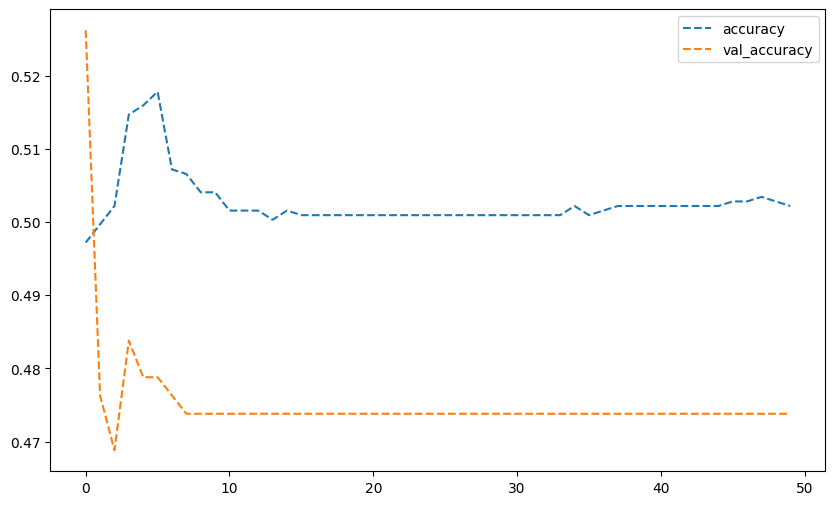

In [44]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [45]:
model.evaluate(training_data_[cols], training_data['direction'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5207 - loss: 0.8811  


[0.8551627397537231, 0.512487530708313]

In [46]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [47]:
pred[:30].flatten()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0])

In [48]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [49]:
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

In [50]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.838998
strategy    0.933475
dtype: float64

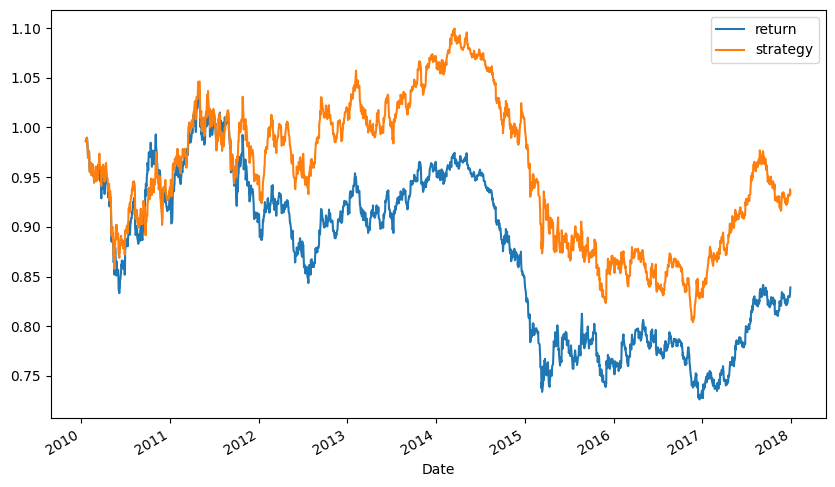

In [51]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_2.png')

In [52]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5022 - loss: 0.8022 


[0.7989351153373718, 0.487077534198761]

In [53]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [54]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [55]:
test_data['prediction'].value_counts()

prediction
 1    452
-1     51
Name: count, dtype: int64

In [56]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [57]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    0.926654
dtype: float64

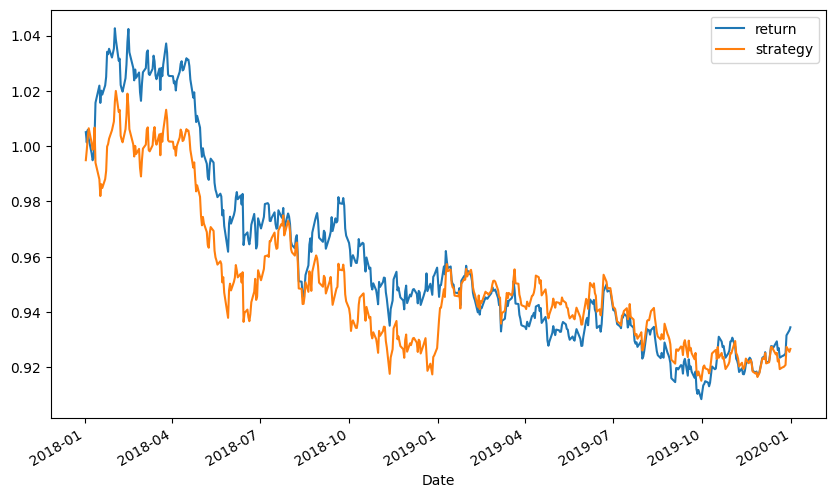

In [58]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));